<a href="https://colab.research.google.com/github/HuyenTrang457/MCM/blob/main/model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1



Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 19.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import pointbiserialr, spearmanr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
# Load the processed dataset
data_path = "/content/dataForModel2.csv"  # Replace with your actual processed data file path
data = pd.read_csv(data_path)


In [ ]:
string_columns = data.select_dtypes(include=['object', 'string']).columns
print("Các cột chứa giá trị dạng chuỗi:", string_columns)

Các cột chứa giá trị dạng chuỗi: Index(['match_id', 'player1', 'player2', 'winner_shot_type'], dtype='object')


In [ ]:
correlation_results = {}
features = [
    'sets_diff', 'games_diff', 'score_diff', 'points_won_diff',
    'ace_diff', 'double_fault_diff', 'server_is_p1','first_serve',
    'p1_game_win_ratio', 'p1_set_win_ratio', 'distance_diff',
    'p1_point_win_ratio', 'p1_ace_ratio',
    'p1_double_fault_ratio','server', 'serve_width', 'serve_depth', 'return_depth','point_victor_p1'
]
continuous_features = [
    'sets_diff', 'games_diff', 'score_diff', 'points_won_diff',
    'ace_diff','first_serve',
    'p1_game_win_ratio', 'p1_set_win_ratio', 'distance_diff',
    'p1_point_win_ratio', 'p1_ace_ratio',
    'server'
]
for col in continuous_features:  # continuous_cols là danh sách các feature liên tục
    corr, p_value = pointbiserialr(data[col], data['point_victor'])
    correlation_results[col] = {'correlation': corr, 'p_value': p_value}

# Kết quả
correlation_df = pd.DataFrame(correlation_results).T
print(correlation_df)

                    correlation        p_value
sets_diff             -0.024416   4.906101e-02
games_diff             0.066461   8.216156e-08
score_diff            -0.169347   5.246832e-43
points_won_diff       -0.124210   9.224933e-24
ace_diff              -0.312154  7.703364e-147
first_serve            0.018430   1.374100e-01
p1_game_win_ratio      0.076783   5.739863e-10
p1_set_win_ratio      -0.025953   3.643511e-02
distance_diff          0.118794   7.380483e-22
p1_point_win_ratio    -0.166928   8.070291e-42
p1_ace_ratio          -0.225192   1.703753e-75
server                 0.409444  3.519202e-261


Ưu điểm:
Biến quan trọng có tương quan cao:
server có tương quan cao nhất (correlation = 0.409, p-value rất nhỏ), là một đặc trưng quan trọng trong dự đoán.
Các biến khác như ace_diff, score_diff, p1_point_win_ratio, và p1_ace_ratio cũng có ý nghĩa thống kê (p-value < 0.05), dù mức độ tương quan không bằng server.
Sự đa dạng trong đặc trưng:
Dữ liệu bao gồm các nhóm đặc trưng đa dạng như hiệu suất (e.g., score_diff, points_won_diff), chiến thuật (e.g., ace_diff, first_serve), và hiệu quả (e.g., p1_game_win_ratio), mang lại tiềm năng tốt cho mô hình hóa.
Nhược điểm:
Tương quan thấp:
Hầu hết các biến (ngoại trừ server và ace_diff) có tương quan thấp với biến mục tiêu, thường dao động từ 0.01 đến 0.07, có thể làm giảm độ chính xác của mô hình.
Một số biến không ý nghĩa:
Biến như first_serve và p1_set_win_ratio có p-value lớn và tương quan thấp, cho thấy ít đóng góp vào mô hình dự đoán.

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ví dụ: Chọn các cột liên quan (thay bằng các cột của bạn)

# Tạo một DataFrame chỉ chứa các biến độc lập
X = data[continuous_features]

# Thêm một cột hằng số (cần thiết để tính VIF)
X = X.assign(const=1)

# Tính toán VIF cho từng biến
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Hiển thị kết quả
print(vif_data)


              Variable        VIF
0            sets_diff   4.269677
1           games_diff   2.263485
2           score_diff   1.247923
3      points_won_diff   3.603271
4             ace_diff   2.371512
5          first_serve   1.051917
6    p1_game_win_ratio   1.753232
7     p1_set_win_ratio   2.631082
8        distance_diff   1.169128
9   p1_point_win_ratio   1.489853
10        p1_ace_ratio   2.307984
11              server   1.523803
12               const  90.509071


Biến không có đa cộng tuyến đáng kể:

Hầu hết các biến có
VIF
<
5
VIF<5, cho thấy mức độ đa cộng tuyến thấp và có thể được giữ lại trong mô hình.
Cụ thể, các biến như score_diff (
1.25
1.25), first_serve (
1.05
1.05), và distance_diff (
1.17
1.17) có VIF rất thấp, hoàn toàn không gây đa cộng tuyến.
Biến có đa cộng tuyến vừa phải:

sets_diff (
4.27
4.27), points_won_diff (
3.60
3.60), và p1_set_win_ratio (
2.63
2.63) có VIF dưới ngưỡng 5 nhưng tương đối cao hơn các biến khác. Cần theo dõi để tránh ảnh hưởng lớn nếu thêm nhiều biến tương quan chặt chẽ.
Hệ số chặn (const) có VIF rất cao:

const có
VIF
=
90.51
VIF=90.51, điều này là bình thường vì nó đại diện cho hằng số trong mô hình, không ảnh hưởng đến phân tích.


In [ ]:
# Tính đạo hàm riêng
sensitivity_results = {}

for col in continuous_features:
    X = data[[col]]
    y = data['point_victor']
    model = LogisticRegression(random_state=42)
    model.fit(X, y)
    prob = model.predict_proba(X)[:, 1]
    beta = model.coef_[0][0]
    sensitivity = prob * (1 - prob) * beta
    sensitivity_results[col] = {'mean_sensitivity': np.mean(sensitivity)}

# Kết quả
sensitivity_df = pd.DataFrame(sensitivity_results).T
print(sensitivity_df)


                    mean_sensitivity
sets_diff                  -0.012195
games_diff                  0.033239
score_diff                 -0.084705
points_won_diff            -0.062211
ace_diff                   -1.099836
first_serve                 0.019453
p1_game_win_ratio           0.038367
p1_set_win_ratio           -0.032744
distance_diff               0.012339
p1_point_win_ratio         -1.172695
p1_ace_ratio               -0.361593
server                      0.361776


Biến quan trọng với độ nhạy cao:

p1_point_win_ratio (
−
1.1727
−1.1727): Có độ nhạy cao nhất, cho thấy tỷ lệ điểm thắng của Player 1 có ảnh hưởng mạnh đến biến mục tiêu. Hệ số âm chỉ ra mối quan hệ nghịch.
ace_diff (
−
1.0998
−1.0998): Sự chênh lệch cú ace giữa hai người chơi cũng có tác động mạnh mẽ, với mối quan hệ nghịch.
Biến ảnh hưởng đáng kể:

p1_ace_ratio (
−
0.3616
−0.3616) và server (
0.3618
0.3618) có độ nhạy tương đối lớn, chỉ ra chúng là các yếu tố có ý nghĩa trong mô hình.
score_diff (
−
0.0847
−0.0847) và points_won_diff (
−
0.0622
−0.0622) cũng đóng góp đáng kể, mặc dù nhỏ hơn các biến kể trên.
Biến ảnh hưởng nhẹ:

Các biến như games_diff (
0.0332
0.0332), p1_game_win_ratio (
0.0384
0.0384), và first_serve (
0.0195
0.0195) có độ nhạy thấp hơn nhưng vẫn có tác động nhỏ đến biến mục tiêu.
Biến ít ảnh hưởng:

distance_diff (
0.0123
0.0123) và sets_diff (
−
0.0122
−0.0122) có độ nhạy rất nhỏ, cho thấy ảnh hưởng không đáng kể đến biến mục tiêu.


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Tính Mutual Information
mi_scores = mutual_info_classif(data[continuous_features], data['point_victor'], discrete_features=False)

# Kết quả dưới dạng DataFrame
mi_df = pd.DataFrame({'feature': continuous_features, 'mi_score': mi_scores})
mi_df.sort_values(by='mi_score', ascending=False, inplace=True)
print(mi_df)


               feature  mi_score
11              server  0.090099
4             ace_diff  0.062403
10        p1_ace_ratio  0.026742
8        distance_diff  0.026477
2           score_diff  0.018611
9   p1_point_win_ratio  0.018326
1           games_diff  0.015444
6    p1_game_win_ratio  0.014043
3      points_won_diff  0.010036
5          first_serve  0.001448
0            sets_diff  0.000000
7     p1_set_win_ratio  0.000000


iến có mức độ thông tin cao:

server (
𝑀
𝐼
=
0.0901
MI=0.0901) và ace_diff (
𝑀
𝐼
=
0.0624
MI=0.0624) có điểm Mutual Information cao nhất, cho thấy chúng chứa nhiều thông tin hữu ích để dự đoán biến mục tiêu.
p1_ace_ratio (
𝑀
𝐼
=
0.0267
MI=0.0267) và distance_diff (
𝑀
𝐼
=
0.0265
MI=0.0265) cũng có mức độ đóng góp đáng kể.
Biến có mức độ thông tin trung bình:

score_diff (
𝑀
𝐼
=
0.0186
MI=0.0186) và p1_point_win_ratio (
𝑀
𝐼
=
0.0183
MI=0.0183) có mức độ thông tin thấp hơn nhưng vẫn đáng kể.
games_diff (
𝑀
𝐼
=
0.0154
MI=0.0154) và p1_game_win_ratio (
𝑀
𝐼
=
0.0140
MI=0.0140) nằm ở mức thấp hơn nhưng có thể hỗ trợ mô hình.
Biến có mức độ thông tin rất thấp:

first_serve (
𝑀
𝐼
=
0.0014
MI=0.0014) đóng góp rất ít thông tin.
sets_diff và p1_set_win_ratio (
𝑀
𝐼
=
0
MI=0) không có đóng góp thông tin cho biến mục tiêu, có thể loại bỏ.

In [ ]:
print(data.dtypes)


match_id                  object
player1                   object
player2                   object
set_no                     int64
game_no                    int64
                          ...   
p1_game_win_ratio        float64
p1_set_win_ratio         float64
p1_point_win_ratio       float64
p1_ace_ratio             float64
p1_double_fault_ratio    float64
Length: 61, dtype: object


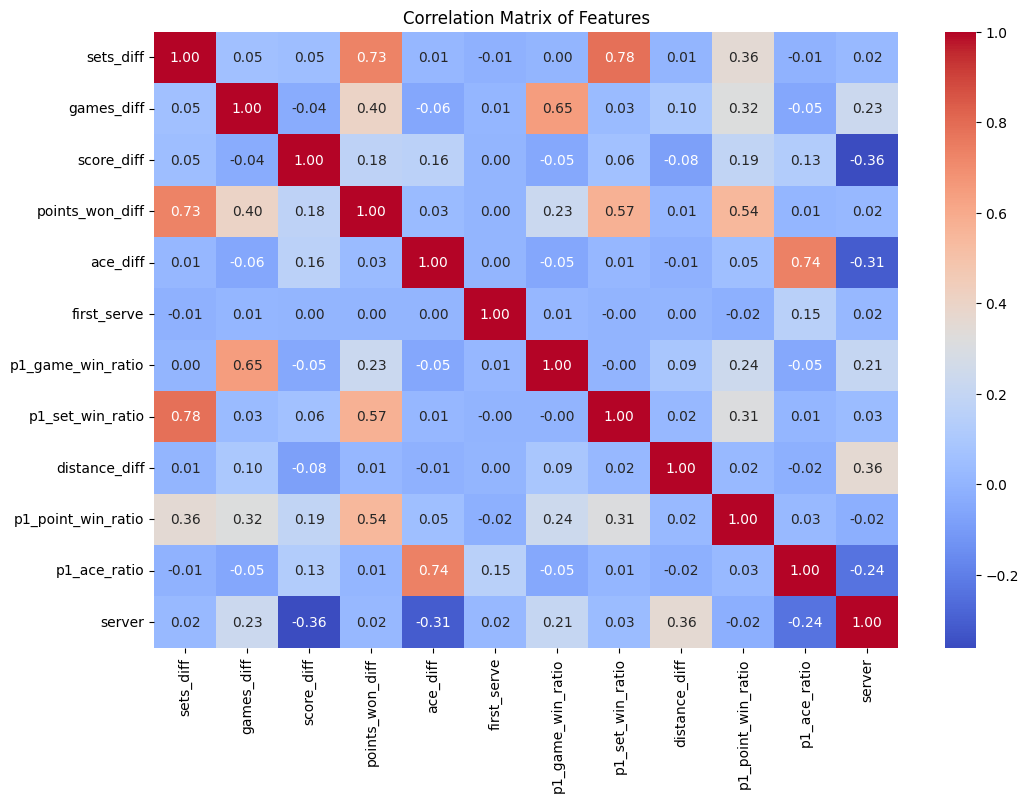

Các cặp biến có tương quan mạnh (> 0.7):
sets_diff         p1_set_win_ratio    0.784959
p1_set_win_ratio  sets_diff           0.784959
ace_diff          p1_ace_ratio        0.737606
p1_ace_ratio      ace_diff            0.737606
sets_diff         points_won_diff     0.731339
points_won_diff   sets_diff           0.731339
dtype: float64


In [ ]:
# Loại bỏ cột 'match_id' khỏi data
data_numeric = data[continuous_features]

# Tính ma trận tương quan
correlation_matrix = data_numeric.corr(method='pearson')

# Vẽ heatmap trực quan hóa ma trận tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features")
plt.show()

# Tìm các cặp biến có tương quan mạnh (> 0.7)
high_corr_pairs = correlation_matrix.stack()[(correlation_matrix.stack() > 0.7) & (correlation_matrix.stack() < 1)]
print("Các cặp biến có tương quan mạnh (> 0.7):")
print(high_corr_pairs.sort_values(ascending=False))


In [ ]:
# Re-importing necessary libraries after the reset
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming 'data' is preloaded, otherwise re-import it
# Splitting the data into features (X) and target (y)
X = data[features].drop(columns=['point_victor_p1'])  # Dữ liệu đầu vào (các feature)
y = data['point_victor_p1']                # Mục tiêu (0 hoặc 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Extracting feature importance
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Evaluating model performance on test set
y_pred = xgb_model.predict(X_test)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report on Test Set:")
print(classification_rep)


Classification Report on Test Set:
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1300.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1300.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1300.0}}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:09:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Feature Importances (XGBoost):
Empty DataFrame
Columns: [Feature, Importance]
Index: []


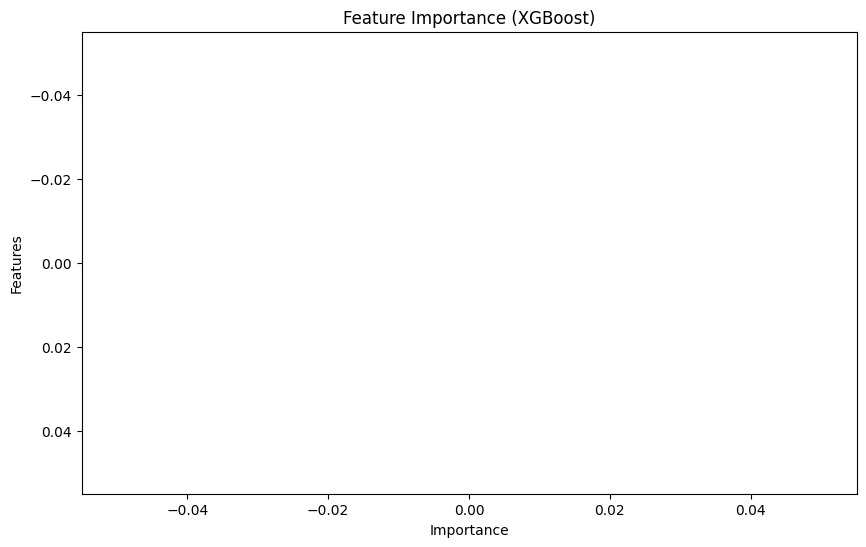

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Nếu mô hình của bạn là mô hình XGBoost đã được huấn luyện

# Trích xuất feature importance
feature_importances = xgb_model.get_booster().get_score(importance_type="weight")
feature_importances_df = pd.DataFrame({
    'Feature': list(feature_importances.keys()),
    'Importance': list(feature_importances.values())
}).sort_values(by="Importance", ascending=False)

print("Feature Importances (XGBoost):")
print(feature_importances_df)

# Vẽ biểu đồ feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (XGBoost)")
plt.gca().invert_yaxis()  # Đảo ngược trục Y để feature quan trọng nhất ở trên cùng
plt.show()
